In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'intc' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980' # Updated 1/1/21
               , 'acy': '01/18/1998' # Updated 1/1/21
               , 'amd': '03/17/1980' # Updated 1/1/21
               , 'baba': '09/15/2014' # Updated 1/1/21
               , 'bac': '02/19/1973' # Updated 1/1/21
               , 'crm': '06/23/2004' # Updated 1/1/21
               , 'esgv': '09/16/2018' # Updated 1/1/21
               , 'goog': '08/16/2004' # Updated 1/1/21
               , 'ibm': '01/02/1962' # Updated 1/1/21
               , 'idex': '05/23/2007' # Updated 1/1/21
               , 'intc': '03/16/1980' # Updated 1/1/21
               , 'iyw': '05/15/2000'
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986'
               , 'nio': '09/10/2018'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'v': '03/16/2008'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,1.85,1.76,1.82,1.79,17995800.0,1.79,0.016484,0.051136,-0.037634,0.025063,-0.013669,1
2020-12-18,2.05,1.66,1.77,1.98,43235900.0,1.98,-0.118644,0.234940,0.106145,0.054117,0.015894,-1
2020-12-21,2.10,1.91,2.03,2.04,33955100.0,2.04,-0.004926,0.099476,0.030303,0.054504,0.018693,1
2020-12-22,2.40,2.07,2.18,2.14,58256200.0,2.14,0.018349,0.159420,0.049020,0.054710,0.028497,-1
2020-12-23,2.30,2.15,2.21,2.18,27256600.0,2.18,0.013575,0.069767,0.018692,0.051980,0.033305,1
2020-12-24,2.27,2.11,2.21,2.27,19536500.0,2.27,-0.027149,0.075829,0.041284,0.033887,0.049089,-1
2020-12-28,2.60,2.31,2.58,2.34,58774700.0,2.34,0.093023,0.125541,0.030837,0.011583,0.034027,-1
2020-12-29,2.32,2.03,2.32,2.09,42029900.0,2.09,0.099138,0.142857,-0.106838,0.064429,0.006599,1
2020-12-30,2.11,1.95,2.05,1.96,31974900.0,1.96,0.043902,0.082051,-0.062201,0.065315,-0.015645,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.73872832 0.73872832 0.73872832]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

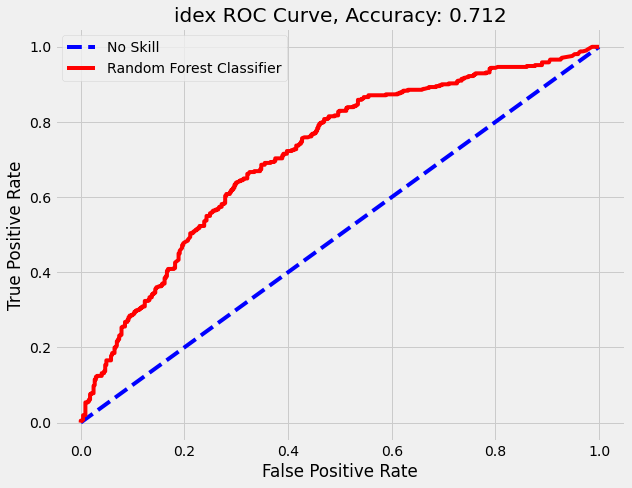

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

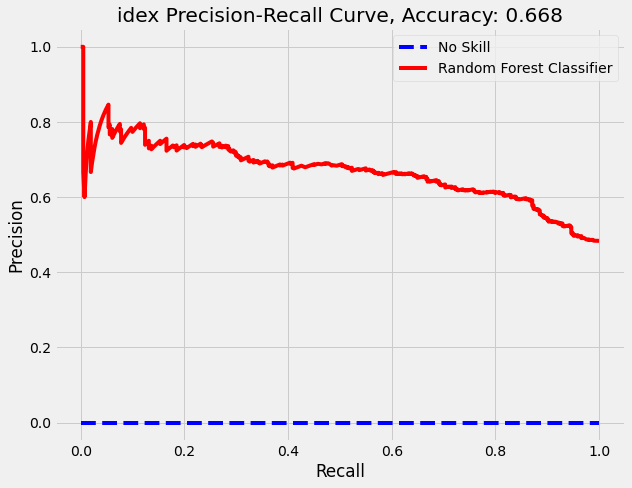

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

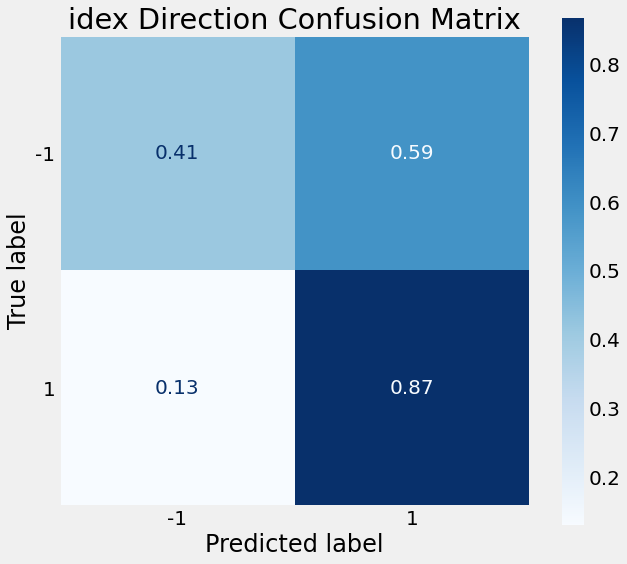

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7001242156486106'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.080000e+00
Low           1.920000e+00
Open          1.990000e+00
Close         1.990000e+00
Volume        2.225390e+07
Adj Close     1.990000e+00
oc            0.000000e+00
hl            8.333332e-02
adj           1.530611e-02
5stdev_adj    6.488595e-02
5sma_adj     -1.632221e-02
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.000000
hl            0.083333
5stdev_adj    0.064886
5sma_adj     -0.016322
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    3422.000000
mean        0.004329
std         0.115802
min        -0.920000
25%        -0.020619
50%         0.000000
75%         0.011081
max         3.000000
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy idex


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,2.27,2.11,2.21,2.27,19536500.0,2.27,-0.027149,0.075829,0.041284,0.033887,0.049089,-1,-1,-0.030837
2020-12-28,2.60,2.31,2.58,2.34,58774700.0,2.34,0.093023,0.125541,0.030837,0.011583,0.034027,-1,1,-0.106838
2020-12-29,2.32,2.03,2.32,2.09,42029900.0,2.09,0.099138,0.142857,-0.106838,0.064429,0.006599,1,1,-0.062201
2020-12-30,2.11,1.95,2.05,1.96,31974900.0,1.96,0.043902,0.082051,-0.062201,0.065315,-0.015645,1,1,0.015306
2020-12-31,2.08,1.92,1.99,1.99,22253900.0,1.99,0.000000,0.083333,0.015306,0.064886,-0.016322,-1,1,0.000000


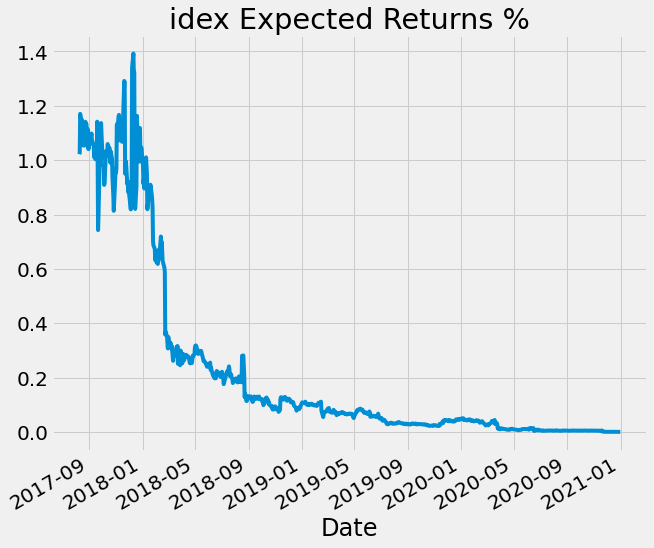

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

0.21407607143191176

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

-0.46933333079020184

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/